# <center> Lecture14 : Hierarchical Models </center>  
 
## <center> Instructor: Dr. Hu Chuan-Peng </center> 

在本节课中，我们将介绍层级模型(hierarchical model)。主要内容：  
- 了解层级数据结构的形式  
- 三种对待处理层级数据的思路：完全池化(complete pooling),  非池化(no pooling), 部分池化(patial pooling)  
- 了解组间变异(between variability)和组内变异(within variability)的差异  
- 通过pymc实现三种不同的模型，并理解分层模型的意义  

> 注：层级模型有许多别名，多层线性模型（Hierarchical Linear Model，HLM），也叫多水平模型（Multilevel Model，MLM），线性混合模型（Linear Mixed Model）混合效应模型（Mixed Effects Model）随机效应模型（Random Effects Model)

## 层级数据结构

在心理学实验中，层级数据或分组数据(hierarchical or grouped data)十分常见，例如：  

1. 设计不同的实验条件，在同一实验条件下收集多个数据(实验条件为组)  
2. 划分不同的人群，在同类人群中收集多个数据(人群为组)  
3. 在一种实验条件内，被试需要重复对同种刺激做出反应(被试为组)  

![Image Name](https://cdn.kesci.com/upload/image/rmcuwtjhi2.png?imageView2/0/w/960/h/960)  

在我们之前使用的数据中，层级数据表现为来自多个站点的自我控制分数  

> * 数据来源: Hu, C.-P. et al. (2018). Raw data from the Human Penguin Project. Open Science Framework. https://doi.org/10.17605/OSF.IO/H52D3   
> * 自我控制量表来源：Tangney, J. P., Baumeister, R. F. & Boone, A. L. High self-control predicts good adjustment, less pathology, better grades, and interpersonal success. J. Pers. 72, 271–324 (2004).

In [1]:
# 导入 pymc 模型包，和 arviz 等分析工具 
import pymc as pm
import arviz as az
import seaborn as sns
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import ipywidgets
import bambi as bmb

# 忽略不必要的警告
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 通过 pd.read_csv 加载数据 Data_Sum_HPP_Multi_Site_Share.csv
# df_raw = pd.read_csv('/home/mw/input/bayes20238001/Data_Sum_HPP_Multi_Site_Share.csv')

df_raw = pd.read_csv('Data_Sum_HPP_Multi_Site_Share.csv')

df_raw[["Site","scontrol"]]

Site  scontrol
0     Bamberg        41
1     Bamberg        36
2     Bamberg        31
3     Bamberg        40
4     Bamberg        43
...       ...       ...
1518   Zurich        45
1519   Zurich        39
1520   Zurich        42
1521   Zurich        42
1522   Zurich        42

[1523 rows x 2 columns]

### 数据可视化  

将所有站点的自我控制分数进行可视化，可以发现：  

* 有的组存在较多极端值  

* 组与组之间的均值不同

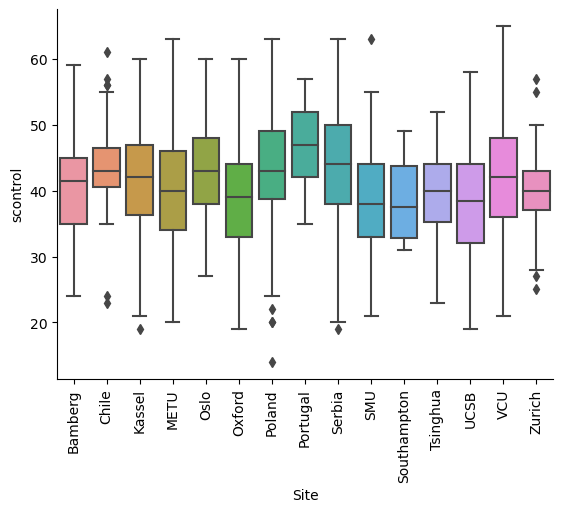

In [3]:
sns.boxplot(data=df_raw,
            x="Site",
            y="scontrol")

plt.xticks(rotation=90) 
sns.despine()
plt.show()

为了方便之后演示，我们仅使用其中5个站点的数据：

In [4]:
# 选取5个站点
first5_site = ['Southampton','METU','Kassel','Tsinghua','Oslo']
df_first5 = df_raw.query("Site in @first5_site")

#为站点生成索引，为被试生成索引
df_first5["site_idx"] = pd.factorize(df_first5.Site)[0]
df_first5["obs_id"] = range(len(df_first5))

#设置索引，方便之后调用数据
df_first5.set_index(['Site','obs_id'],inplace=True,drop=False)
df_first5.head(10)

age   anxiety  anxiety_r  artgluctot  attachhome  \
Site   obs_id                                                        
Kassel 0       1955.0  3.500000   0.323789         0.0    3.222222   
       1       1959.0  1.500000  -1.380456         0.0    4.444444   
       2       1965.0  1.333333  -1.522476         0.0    3.666667   
       3       1966.0  3.222222   0.087088         0.0    4.333333   
       4       1969.0  3.444444   0.276448         0.0    3.555556   
       5       1976.0  2.444444  -0.575674         0.0    4.555556   
       6       1979.0  3.500000   0.323789         0.0    4.111111   
       7       1979.0  1.444444  -1.427796         0.0    4.777778   
       8       1980.0  2.888889  -0.196953         0.0    4.111111   
       9       1981.0  4.555556   1.223251         0.0    4.777778   

               attachphone  AvgHumidity  avgtemp  avoidance  avoidance_r  ...  \
Site   obs_id                                                             ...   
Kassel 0          3.666667         89.0   36.300   3.777778     1.061474  ...   
       1          2.111111          NaN   36.600   2.722222    -0.124879  ...   
       2          2.000000          NaN   35.450   2.611111    -0.249759  ...   
       3          1.000000          NaN   36.630   3.166667     0.374638  ...   
       4          1.444444         69.0   36.465   3.222222     0.437077  ...   
       5          1.444444         73.0   36.500   2.222222    -0.686836  ...   
       6          2.777778         68.0   35.300   3.555556     0.811715  ...   
       7          3.000000         54.0   36.100   2.222222    -0.686836  ...   
       8          2.333333          NaN   36.400   3.388889     0.624396  ...   
       9          3.333333         61.0   36.750   4.000000     1.311232  ...   

               sex    Site  smoke  socialdiversity  socialembedded  socTherm  \
Site   obs_id                                                                  
Kassel 0       1.0  Kassel    2.0                6               3       3.0   
       1       2.0  Kassel    2.0                7               4       2.4   
       2       1.0  Kassel    2.0                5               2       3.8   
       3       2.0  Kassel    2.0                9               2       3.6   
       4       2.0  Kassel    2.0               11               3       2.2   
       5       2.0  Kassel    2.0               12               3       3.2   
       6       1.0  Kassel    2.0                7               2       2.8   
       7       2.0  Kassel    2.0                8               2       3.4   
       8       1.0  Kassel    1.0                9               4       2.8   
       9       2.0  Kassel    2.0                9               3       2.6   

               soliTherm  stress  site_idx  obs_id  
Site   obs_id                                       
Kassel 0           3.125      30         0       0  
       1           3.125      30         0       1  
       2           2.375      31         0       2  
       3           2.875      47         0       3  
       4           2.750      50         0       4  
       5           2.625      42         0       5  
       6           4.125      37         0       6  
       7           2.750      33         0       7  
       8           3.750      42         0       8  
       9           3.875      40         0       9  

[10 rows x 39 columns]

### 数据的层级结构  

![Image Name](https://cdn.kesci.com/upload/s5eeyrh0s5.png?imageView2/0/w/960/h/960)  


* $j$来表示站点，$j \in \{1,2, \ldots, 5\}$  
* $i$来表示站点内部的每一个数据$i \in \{1,2,\ldots,n_j\}$  
* 每一个被试的数据可以被表示为$Y_{ij}$，表示站点$j$内的第$i$个被试的自我控制分数观测值  

$$  
Y := \left((Y_{11}, Y_{21}, \ldots, Y_{n_1,1}), (Y_{12}, Y_{22}, \ldots, Y_{n_2,2}), \ldots, (Y_{1,5}, Y_{2,5}, \ldots, Y_{n_{5},5})\right)  .  
$$  

🤔可以想象，如果我们忽略了数据的分组结构，则可能违反模型使用的前提。  

* 例如，由于反应来自同一个被试，数据点之间是相互关联的，在对被试的反应时使用回归模型时，需要考虑独立性假设是否被违反。  

面对这样的层级数据，我们有三种建模思路(对应三种不同的假设)：  
- 完全池化(complete pooling)  
- 非池化(no pooling)  
- 部分池化(patial pooling)  

## 完全池化(Complete pooling)模型  

* 在完全池化模型中，我们忽略个体的分组信息(Site)，认为这些个体直接来自一个更大的总体  

![Image Name](https://cdn.kesci.com/upload/s5eflzcpoj.png?imageView2/0/w/960/h/960)  


我们可以使用正态模型来建立 complete pooled 模型：  

$$  
\begin{split}  
Y_{ij} | \mu, \sigma & \sim N(\mu, \sigma^2) \\  
\mu    & \sim N(0, 50^2) \\  
\sigma & \sim \text{Exp}(1) \\  
\end{split}  
$$  

**global parameters $\theta$**  

* $\mu$为自我控制分数在**总体**中的均值(global mean)  

* $\sigma$为自我控制分数均值在**总体**中的标准差(global standard deviation)  

![Image Name](https://cdn.kesci.com/upload/image/rmcx1f4dlx.png?imageView2/0/w/960/h/960)  

> 下图给出了所有552个被试自我控制分数的分布情况，分数范围大概在20-60之间

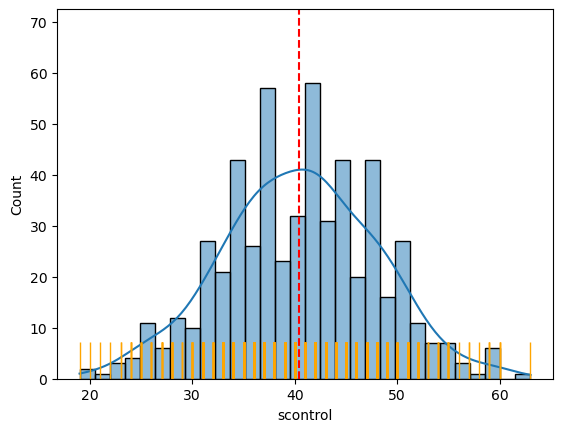

In [5]:
data_scontrol = df_first5["scontrol"]
# 绘制直方图
ax = sns.histplot(data_scontrol, kde=True, bins=30)

# 计算并画出均值线
mean = np.mean(data_scontrol)
ax.axvline(mean, color='red', linestyle='--')

# 在直方图上添加散点以标记每个样本
ax = sns.rugplot(data_scontrol, color="orange", height=0.1)

### 模型定义及MCMC采样  

$$  
\begin{split}  
Y_{ij} | \mu, \sigma & \sim N(\mu, \sigma^2) \\  
\mu    & \sim N(0, 50^2) \\  
\sigma & \sim \text{Exp}(1) \\  
\end{split}  
$$  

根据公式使用 pymc 定义模型：

In [6]:
with pm.Model() as complete_pooled_model:

    #定义beta_0
    mu = pm.Normal("mu", mu=0, sigma=50)  
    #定义sigma                  
    sigma = pm.Exponential("sigma", 1)           
    #定义似然：预测值y符合N(mu, sigma)分布；传入实际数据y 自我控制水平 df_first5.scontrol
    likelihood = pm.Normal("y_est", mu=mu, sigma=sigma, observed=df_first5.scontrol)   
    # 进行采样，默认为 chains=4, samples=1000,burn=1000
    complete_trace = pm.sample(random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.


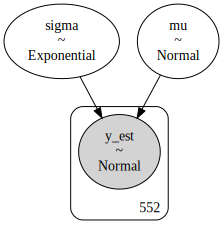

In [7]:
pm.model_to_graphviz(complete_pooled_model)

### 查看后验参数估计

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

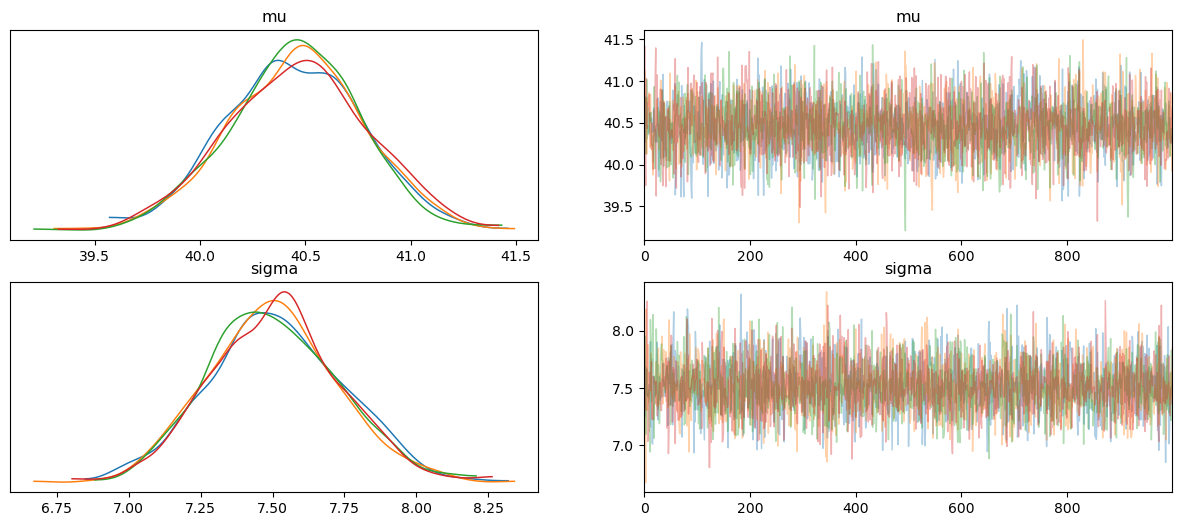

In [8]:
az.plot_trace(complete_trace,
              compact=False,
              figsize=(15,6))

In [9]:
az.summary(complete_trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     40.454  0.323  39.820   41.027      0.005    0.004    4129.0    2922.0   
sigma   7.509  0.229   7.102    7.955      0.003    0.002    4285.0    3023.0   

       r_hat  
mu       1.0  
sigma    1.0

### 后验预测分布  

* 我们可以画出所有预测值的95%后验预测可信区间  

* 同时可以观察真实值落在可信区间的情况  

> (在lec11中，我们介绍过可信区间的绘制，主要借助`az.summary`生成后验预测总结的表格，并判断真实值是否落在可信区间内)

In [10]:
# 进行后验预测
complete_ppc = pm.sample_posterior_predictive(complete_trace,
                                              model=complete_pooled_model)

Sampling: [y_est]


In [11]:
# 定义函数，计算 95%hdi
def ppc_sum(ppc, data):
    
    hdi_sum = az.summary(ppc, hdi_prob=0.95)
    hdi_sum["obs_id"] = data["obs_id"].values
    hdi_sum["y"] = data["scontrol"].values
    hdi_sum["site"] = data["Site"].values

    return hdi_sum

# 计算后验预测的 95%hdi
complete_hdi_sum = ppc_sum(ppc = complete_ppc, data=df_first5)
complete_hdi_sum

mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
y_est[0]    40.833  7.536    25.655     54.805      0.118    0.084    4080.0   
y_est[1]    40.462  7.521    26.679     55.853      0.120    0.085    3900.0   
y_est[2]    40.384  7.408    25.229     54.145      0.116    0.083    4057.0   
y_est[3]    40.365  7.456    26.447     54.979      0.125    0.088    3575.0   
y_est[4]    40.439  7.499    26.615     55.543      0.121    0.085    3854.0   
...            ...    ...       ...        ...        ...      ...       ...   
y_est[547]  40.456  7.443    26.960     55.692      0.117    0.083    4003.0   
y_est[548]  40.473  7.584    26.258     55.629      0.119    0.084    4070.0   
y_est[549]  40.431  7.505    26.178     55.276      0.120    0.085    3901.0   
y_est[550]  40.619  7.409    26.233     54.843      0.117    0.082    4037.0   
y_est[551]  40.543  7.415    26.609     55.914      0.125    0.089    3527.0   

            ess_tail  r_hat  obs_id   y      site  
y_est[0]      3774.0    1.0       0  47    Kassel  
y_est[1]      3889.0    1.0       1  44    Kassel  
y_est[2]      3663.0    1.0       2  47    Kassel  
y_est[3]      3905.0    1.0       3  37    Kassel  
y_est[4]      3832.0    1.0       4  33    Kassel  
...              ...    ...     ...  ..       ...  
y_est[547]    3924.0    1.0     547  52  Tsinghua  
y_est[548]    3973.0    1.0     548  33  Tsinghua  
y_est[549]    3920.0    1.0     549  35  Tsinghua  
y_est[550]    4059.0    1.0     550  38  Tsinghua  
y_est[551]    3611.0    1.0     551  39  Tsinghua  

[552 rows x 12 columns]

In [82]:
# 定义函数绘制超出 95%hdi 的点
from matplotlib.lines import Line2D

def ppc_plot(hdi_sum):
    fig, ax =  plt.subplots(figsize=(15,6))

    #生成颜色条件，根据站点生成不同的颜色（可信区间）
    unique_sites = hdi_sum["site"].unique()
    conditions=[]
    colors=[]
    for i, site in enumerate(unique_sites):
        condition = hdi_sum["site"] == site
        conditions.append(condition)
        color = f"C{i}"
        colors.append(color)
        
    hdi_colors = np.select(conditions,colors)
    #绘制94%的可信区间
    HDI = ax.vlines(hdi_sum["obs_id"], 
            hdi_sum["hdi_2.5%"], hdi_sum["hdi_97.5%"], 
            color=hdi_colors, 
            alpha=0.5,
            label="94% HDI")
    #绘制后验预测均值
    pos_mean = ax.scatter(hdi_sum["obs_id"], hdi_sum["mean"],
            marker="_",
            c = 'black',
            alpha=0.2,
            zorder = 2,
            label="Posterior mean")
    #根据是否落在可信区间内选择不同的颜色
    colors = np.where((hdi_sum["y"] >= hdi_sum["hdi_2.5%"]) & (hdi_sum["y"] <= hdi_sum["hdi_97.5%"]), 
                    '#2F5597', '#C00000')
    #绘制真实值
    ax.scatter(hdi_sum["obs_id"], hdi_sum["y"],
            c = colors,
            alpha=0.7,
            zorder = 2)
    # 设置图例的颜色、形状、名称
    legend_color = ['#2F5597', '#C00000']
    handles = [plt.Line2D([0], [0], 
                        marker='o', 
                        color='w', 
                        markerfacecolor=color, markersize=10) for color in legend_color]
    handles += [HDI]
    handles += [pos_mean]
    labels = ['Within HDI', 'Outside HDI','94%HDI','Posterior mean']

    plt.legend(handles=handles, 
               labels=labels,
               loc='upper right',
               bbox_to_anchor=(1.08, 1))
    # 设置x轴的刻度，根据每个类别的数量确定刻度位置
    count_per_site = hdi_sum.groupby("site").size().values
    cumulative_count = count_per_site.cumsum()
    xtick = cumulative_count - count_per_site / 2
    plt.xticks(xtick, hdi_sum["site"].unique())

    sns.despine()

由于我们省略了分组信息，假测所有的观测值都来自同一正态分布，因此所有观测值的后验预测均值都是相似的  
* 纵坐标为自我控制分数的范围  
* 横坐标代表每个观测值的排序  
* 横线部分表示每个观测值的后验预测均值

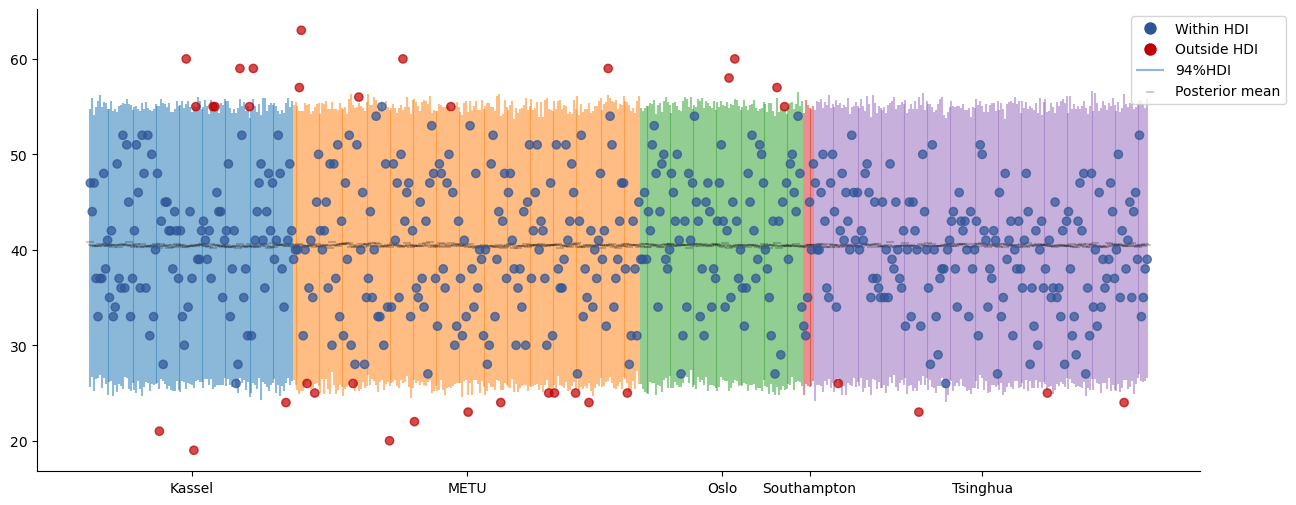

In [79]:
ppc_plot(hdi_sum=complete_hdi_sum)

## No pooling 非池化模型  

在complete pooled模型中，我们忽略了数据来自不同的站点这一事实  

现在我们考虑另外一种情况，我们**假设五个站点分别来自不同的分布，对五个站点进行不同的分析**  
* 注意：我们假定，各站点数据之间完全没有关联，不同站点之间彼此独立。  
* 从统计上讲，假定各站点之间的参数(例如均值$\mu$)没有关系，或者说是完全异质。  

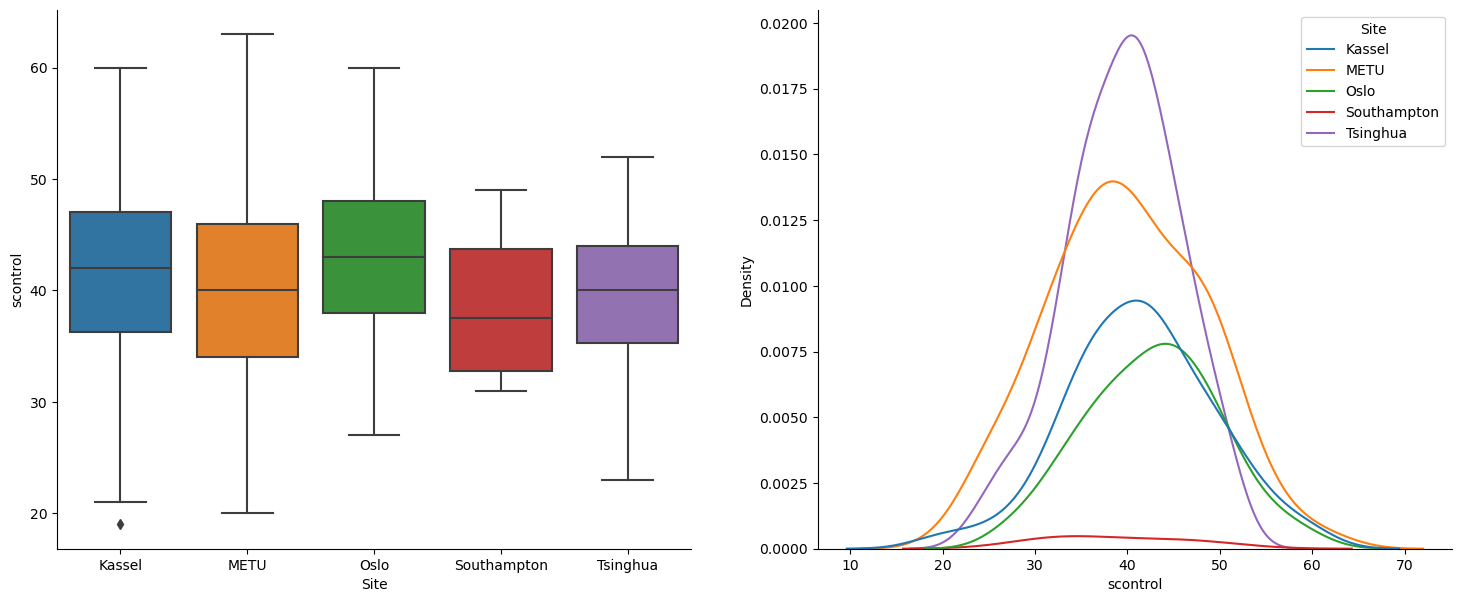

In [14]:
fig, ax = plt.subplots(1,2,figsize=(18,7))
sns.boxplot(data=df_first5,
            x="Site",
            y="scontrol",
            ax=ax[0])

sns.kdeplot(data=df_first5,
            x="scontrol",
            hue="Site",
             ax=ax[1])
sns.despine()

### Group-specific parameters  

* 在完全池化模型中，我们使用了正态分布的参数来自总体层面；  

* 在非池化模型中，我们认为正态分布的参数在组与组之间是不同的(group-specific) ---- 可以认为么个站点的数据对应一个独立的正态分布模型  

![Image Name](https://cdn.kesci.com/upload/s5eh3sji4k.png?imageView2/0/w/960/h/960)  

1. 使用 $\mu_j$ 来表示每个站点的自我控制分数均值  

    * 不同站点的$\mu_j$不同  

    * 同一站点内的个体服从以 $\mu_j$ 为均值的正态分布模型  

3. 同样，使用 $\sigma_j$ 来表示每个站点内部自我控制分数的变异性  

    * 和 $\mu_j$ 类似，不同站点的 $\sigma_j$ 不同  
    * 同一站点内的个体服从以 $\sigma_j$ 为标准差的正态分布模型  


则对于站点 $j$ 内的个体来说，自我控制分数满足：  
$$  
Y_{ij} | \mu_j, \sigma \sim N(\mu_j, \sigma_j^2) \\  

\mu_j  \sim N(0, 50^2) \\  

\sigma_j \sim \text{Exp}(1) \\  
$$  

![Image Name](https://cdn.kesci.com/upload/s5eh3sji4k.png?imageView2/0/w/960/h/960)  

### 模型定义及MCMC采样  

根据公式定义模型：  

$$  
Y_{ij} | \mu_j, \sigma \sim N(\mu_j, \sigma_j^2) \\  

\mu_j  \sim N(0, 50^2) \\  

\sigma_j \sim \text{Exp}(1) \\  
$$  

- 考虑到数据有5个站点，即 j = 1,2,3,4,5。因此，$\mu_j$ 和 $\sigma_j$ 也有5个值。  
- 在pymc中，我们可以通过定义坐标 coords 来实现 `pm.Normal(..., dims="site")  
- 此外，每个个体的数据来自于某个站点，因此可以通过 `pm.MutableData("site", df_first5.site_idx, dims="obs_id")` 来定义个体数据 `obs_id` 和站点 `site` 之间的映射。

In [15]:
coords = {"site": df_first5["Site"].unique(),
          "obs_id": df_first5.obs_id}

with pm.Model(coords=coords) as no_pooled_model:

    #定义mu，指定dims="site"，生成不同的mu 
    mu = pm.Normal("mu", mu=0, sigma=50, dims="site")                  
    #定义sigma，指定dims="site"，生成不同的sigma
    sigma = pm.Exponential("sigma", 2, dims="site")            
    #获得观测值对应的站点映射
    site = pm.MutableData("site", df_first5.site_idx, dims="obs_id") 
    # 定义 likelihood
    likelihood = pm.Normal("y_est", mu=mu[site], sigma=sigma[site], observed=df_first5.scontrol, dims="obs_id")

    no_trace = pm.sample(random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.


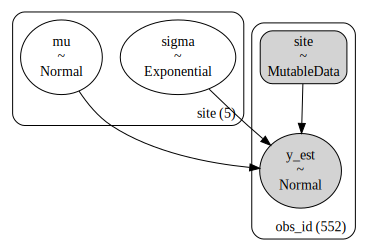

In [16]:
pm.model_to_graphviz(no_pooled_model)

### 查看后验参数估计  

- 可以发现，对于每个站点，均有不同的参数值 (包括 $\mu$ 和 $\sigma$)

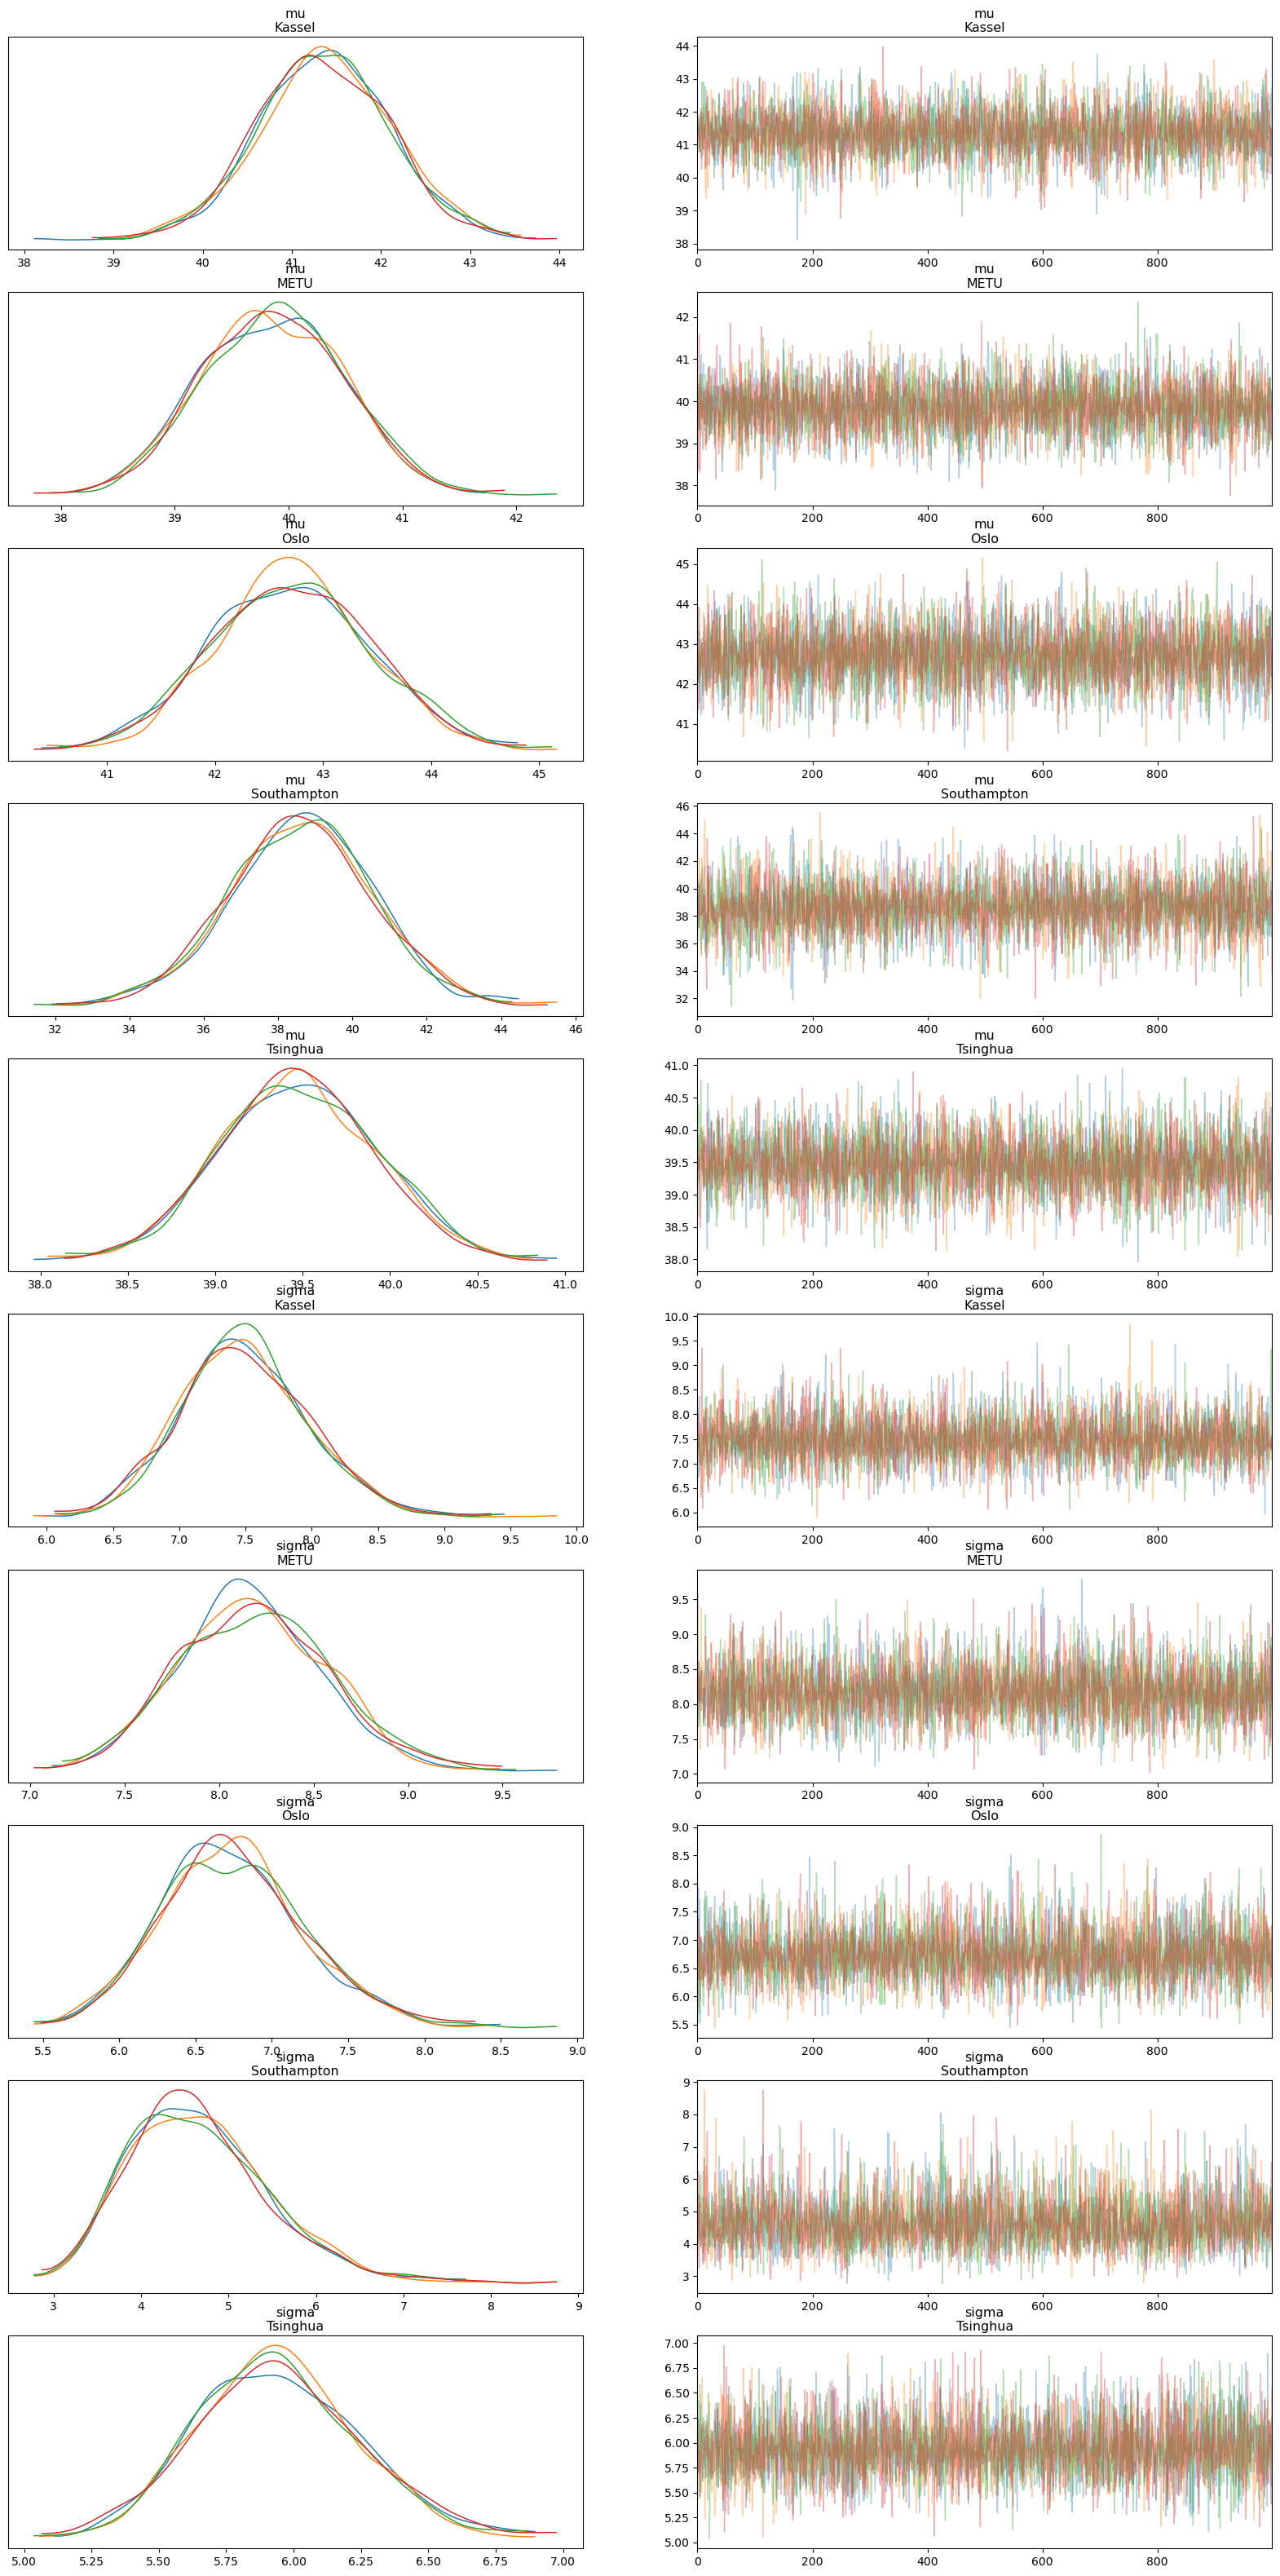

In [86]:
ax = az.plot_trace(
    no_trace,
    compact=False,
    figsize=(20,40))

In [18]:
az.summary(no_trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
mu[Kassel]          41.358  0.738  39.991   42.810      0.010    0.007   
mu[METU]            39.862  0.620  38.717   41.010      0.008    0.006   
mu[Oslo]            42.711  0.729  41.361   44.085      0.009    0.007   
mu[Southampton]     38.610  1.935  34.969   42.275      0.027    0.019   
mu[Tsinghua]        39.470  0.447  38.624   40.284      0.006    0.004   
sigma[Kassel]        7.492  0.487   6.573    8.374      0.006    0.005   
sigma[METU]          8.183  0.398   7.468    8.953      0.005    0.004   
sigma[Oslo]          6.743  0.475   5.832    7.620      0.007    0.005   
sigma[Southampton]   4.667  0.818   3.258    6.202      0.012    0.009   
sigma[Tsinghua]      5.941  0.301   5.416    6.537      0.004    0.003   

                    ess_bulk  ess_tail  r_hat  
mu[Kassel]            5549.0    3164.0    1.0  
mu[METU]              5592.0    2960.0    1.0  
mu[Oslo]              6157.0    3004.0    1.0  
mu[Southampton]       5283.0    2963.0    1.0  
mu[Tsinghua]          5913.0    3192.0    1.0  
sigma[Kassel]         6101.0    2921.0    1.0  
sigma[METU]           5569.0    3232.0    1.0  
sigma[Oslo]           5463.0    2862.0    1.0  
sigma[Southampton]    4877.0    2939.0    1.0  
sigma[Tsinghua]       5319.0    2842.0    1.0

### 后验预测分布

In [19]:
no_ppc = pm.sample_posterior_predictive(no_trace,
                                        model=no_pooled_model)

Sampling: [y_est]


In [20]:
no_hdi_sum = ppc_sum(ppc = no_ppc,
                data=df_first5)

### 非池化模型的缺点  

可以看到在非池化模型中，每个组的均值与方差都是不同的，非池化模型充分考虑了每个组内部的情况，然而，这种模型的缺点可能包括：  

1. 在小样本数据上，非池化模型存在过拟合的风险(如对于站点Southampton)  

2. 非池化模型假设每个组都属于不同的分布，因此其得出的结果难以用来预测新组别的情况

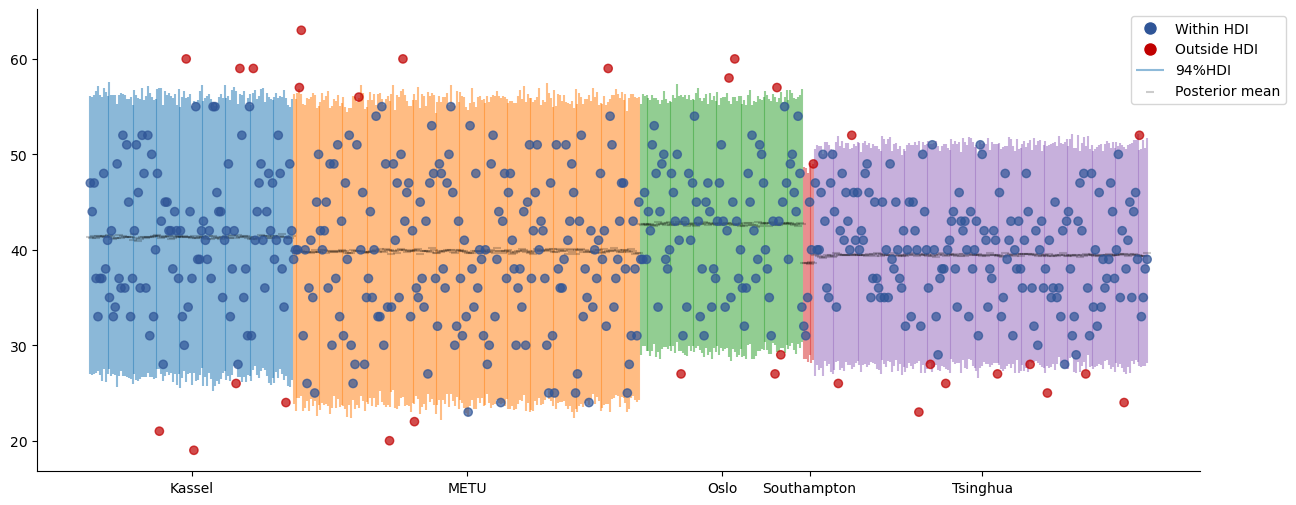

In [84]:
ppc_plot(hdi_sum=no_hdi_sum)

## Partial pooling  

- 完全池化模型仅考虑了个体差异，没有考虑站点之间的差异。  
- 非池化模型考虑了站点的差异，但是容易受到站点内部数据的影响，忽视了站点间可能存在的关系。  

部分池化 (Partial pooling)方法，是构建分层模型的关键。  
- 它假设，不同站点 (layer2) 来自于一个关于站点的总体 (layer1)，站点形式的分布提供了对于组间变异(between variability)的解释。  
- 此外，不同个体 (layer3) 又来自于不同站点 (layer2) ，每个站点内部个体形成的分布提供了对于组内变异(within variability)的解释。  

![Image Name](https://cdn.kesci.com/upload/s5enwlkkz8.png?imageView2/0/w/960/h/960)  

### 对层级模型的定义  

层级模型的数学形式：  

$$  
\begin{array}{lrl}  
\text{Layer 1:} \hspace{0.5in} Y_{ij} | \mu_j, \sigma_y \sim N(\mu_j, \sigma_y^2) \hspace{0.05in} \text{根据站点均值生成个体数据}\\  

\text{Layer 2:} \hspace{0.5in} \mu_j | \mu, \sigma_\mu \stackrel{ind}{\sim} N(\mu, \sigma_\mu^2) \hspace{0.13in} \text{生成不同站点的均值}\\  

\text{Layer 3:}  \hspace{0.5in}\mu,\sigma_y,\sigma_\mu \hspace{0.85in}{超参数}\\  
\hspace{1in}\mu \sim N(40, 20^2) \\  
\hspace{1in}\sigma_y \sim \text{Exp}(1) \text{自我控制分数在组内的变异性} \\  
\hspace{1in} \sigma_\mu \sim \text{Exp}(1) \text{均值在组间的变异性} \\  
\end{array}  
$$  


1. 在最上层：  
    * 使用$\mu$来表示总体的$Y$(global average)，即总体而言，自我控制分数的均值  
    * 使用$\sigma_\mu$来表示组与组之间在$Y$均值上的变异性  
    * 使用$\sigma_y$来表示每个组内部$Y$的变异性(这里我们假设每个组内部的变异性相同)  
2. 在第二层：  
    * 使用$\mu_j$来表示每个组$Y$的均值，而$\mu_j$服从$N(\mu, \sigma_\mu^2)$，这两个参数是从上一层得到的  
3. 在第三层：  
    * 使用$Y_{ij}$来表示组内每个个体的$Y$，而$Y_{ij}$服从$N(\mu_j, \sigma_y^2)$，这两个参数是从上一层得到的  

![Image Name](https://cdn.kesci.com/upload/s5enwlkkz8.png?imageView2/0/w/500/h/500)  



### 另一种定义方式  

* 我们也可以这样来理解层级模型：  

    * $\mu_j$表示：每个站点的自我控制均分  

    * $\sigma_\mu$表示：$\mu_j$偏离总体自我控制均分$\mu$的程度  

* 那么，$\mu_j$与$\mu$的关系式可以写为：  

$$  
\mu_j = \mu + b_{j}  
$$  

* 同时，$b_j$满足  
$$  
b_j \sim N(0, \sigma_\mu^2)  
$$  

* 那么层级模型的Layer1 和 Layer2也可以写为：  

$$  
\begin{split}  
Y_{ij} | \mu_j, \sigma_y & \sim N(\mu_j, \sigma_y^2) \;\; \text{ with } \;\; \mu_j = \mu + b_{j}  \\  
b_{j} | \sigma_\mu    & \stackrel{ind}{\sim} N(0, \sigma_\mu^2) \\  
\mu           & \sim N(40, 20^2) \\  
\sigma_y      & \sim \text{Exp}(1) \\  
\sigma_\mu    & \sim \text{Exp}(1) \\  
\end{split}  
$$

### 模型定义及MCMC采样  

根据公式定义模型：  

$$  
\begin{array}{lrl}  
\text{Layer 1:} \hspace{0.5in} Y_{ij} | \mu_j, \sigma_y \sim N(\mu_j, \sigma_y^2) \hspace{0.05in} \text{根据站点均值生成个体数据}\\  

\text{Layer 2:} \hspace{0.5in} \mu_j | \mu, \sigma_\mu \stackrel{ind}{\sim} N(\mu, \sigma_\mu^2) \hspace{0.13in} \text{生成不同站点的均值}\\  

\text{Layer 3:}  \hspace{0.5in}\mu,\sigma_y,\sigma_\mu \hspace{0.85in}{超参数}\\  
\hspace{1in}\mu \sim N(40, 20^2) \\  
\hspace{1in}\sigma_y \sim \text{Exp}(1) \text{自我控制分数在组内的变异性} \\  
\hspace{1in} \sigma_\mu \sim \text{Exp}(1) \text{均值在组间的变异性} \\  
\end{array}  
$$  

- 相对于非池化模型。部分池化模型的关键在于定义，站点参数在总体上的变异，即 `mu = pm.Normal("mu", mu=hyper_mu, sigma=var_mu, dims="site")`  
- 其次，是相似于非池化模型，个体数据在不同站点分布上的变异 `pm.Normal("y_est", mu=mu[site], sigma=var_y, observed=df_first5.scontrol, dims="obs_id")`  


In [22]:
with pm.Model(coords=coords) as partial_pooled_model:
    # Hyperpriors,定义全局参数
    var_y = pm.Exponential("within_variability", 1)
    var_mu = pm.Exponential("between_variability", 1)
    hyper_mu = pm.Normal("hyper_mu", mu=40, sigma=20)
    # 定义站点参数
    mu = pm.Normal("mu", mu=hyper_mu, sigma=var_mu, dims="site")
    #获得观测值对应的站点映射
    site = pm.MutableData("site", df_first5.site_idx, dims="obs_id")
    # 定义 likelihood
    likelihood = pm.Normal("y_est", mu=mu[site], sigma=var_y, observed=df_first5.scontrol, dims="obs_id")

    partial_trace = pm.sample(random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [within_variability, between_variability, hyper_mu, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
There were 105 divergences after tuning. Increase `target_accept` or reparameterize.


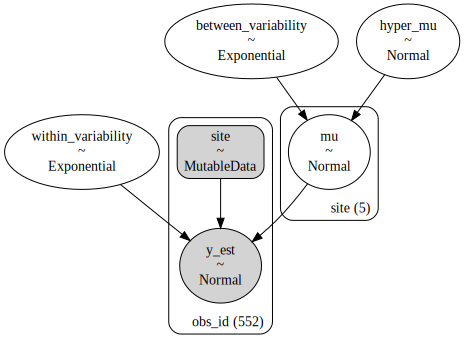

In [23]:
pm.model_to_graphviz(partial_pooled_model)

In [24]:
with pm.Model(coords=coords) as partial_pooled_model_2:
    # Hyperpriors
    var_y = pm.Exponential("within_variability", 1)
    var_mu = pm.Exponential("between_variability", 1)
    hyper_mu = pm.Normal("hyper_mu", mu=40, sigma=20)
    mu_j = pm.Normal("mu_j", mu=0, sigma=var_mu, dims="site")
    mu = pm.Deterministic("mu", mu_j + hyper_mu)

    site = pm.MutableData("site", df_first5.site_idx, dims="obs_id")

    likelihood = pm.Normal("y_est", mu=mu[site], sigma=var_y, observed=df_first5.scontrol, dims="obs_id")

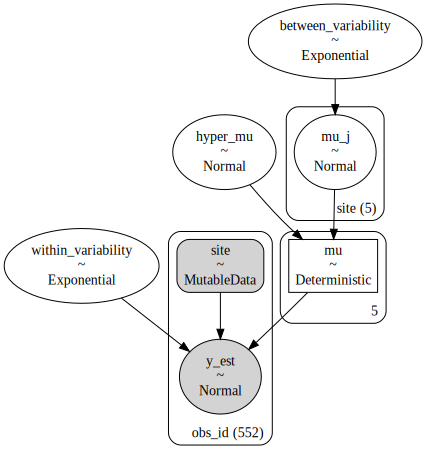

In [25]:
pm.model_to_graphviz(partial_pooled_model_2)

### 查看后验参数估计  

可以发现，  
* 不同站点的均值 $\mu[?]$ 接近站点的总体均值 $\text{hyper}\mu$  
* 此外，组间变异和组内变异的结果也直观的显示了

In [26]:
az.summary(partial_trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
hyper_mu             40.621  0.728  39.330   42.098      0.015    0.010   
mu[Kassel]           41.101  0.645  39.950   42.381      0.016    0.011   
mu[METU]             40.039  0.525  39.012   40.981      0.009    0.006   
mu[Oslo]             41.925  0.802  40.432   43.378      0.023    0.016   
mu[Southampton]      40.324  1.329  37.615   42.753      0.025    0.018   
mu[Tsinghua]         39.747  0.535  38.737   40.699      0.012    0.008   
within_variability    7.457  0.225   7.043    7.890      0.004    0.003   
between_variability   1.231  0.608   0.297    2.306      0.018    0.013   

                     ess_bulk  ess_tail  r_hat  
hyper_mu               2419.0    2645.0    1.0  
mu[Kassel]             1658.0     891.0    1.0  
mu[METU]               3306.0    2520.0    1.0  
mu[Oslo]               1119.0     297.0    1.0  
mu[Southampton]        3092.0    2360.0    1.0  
mu[Tsinghua]           2057.0    1949.0    1.0  
within_variability     2872.0    2644.0    1.0  
between_variability     701.0     286.0    1.0

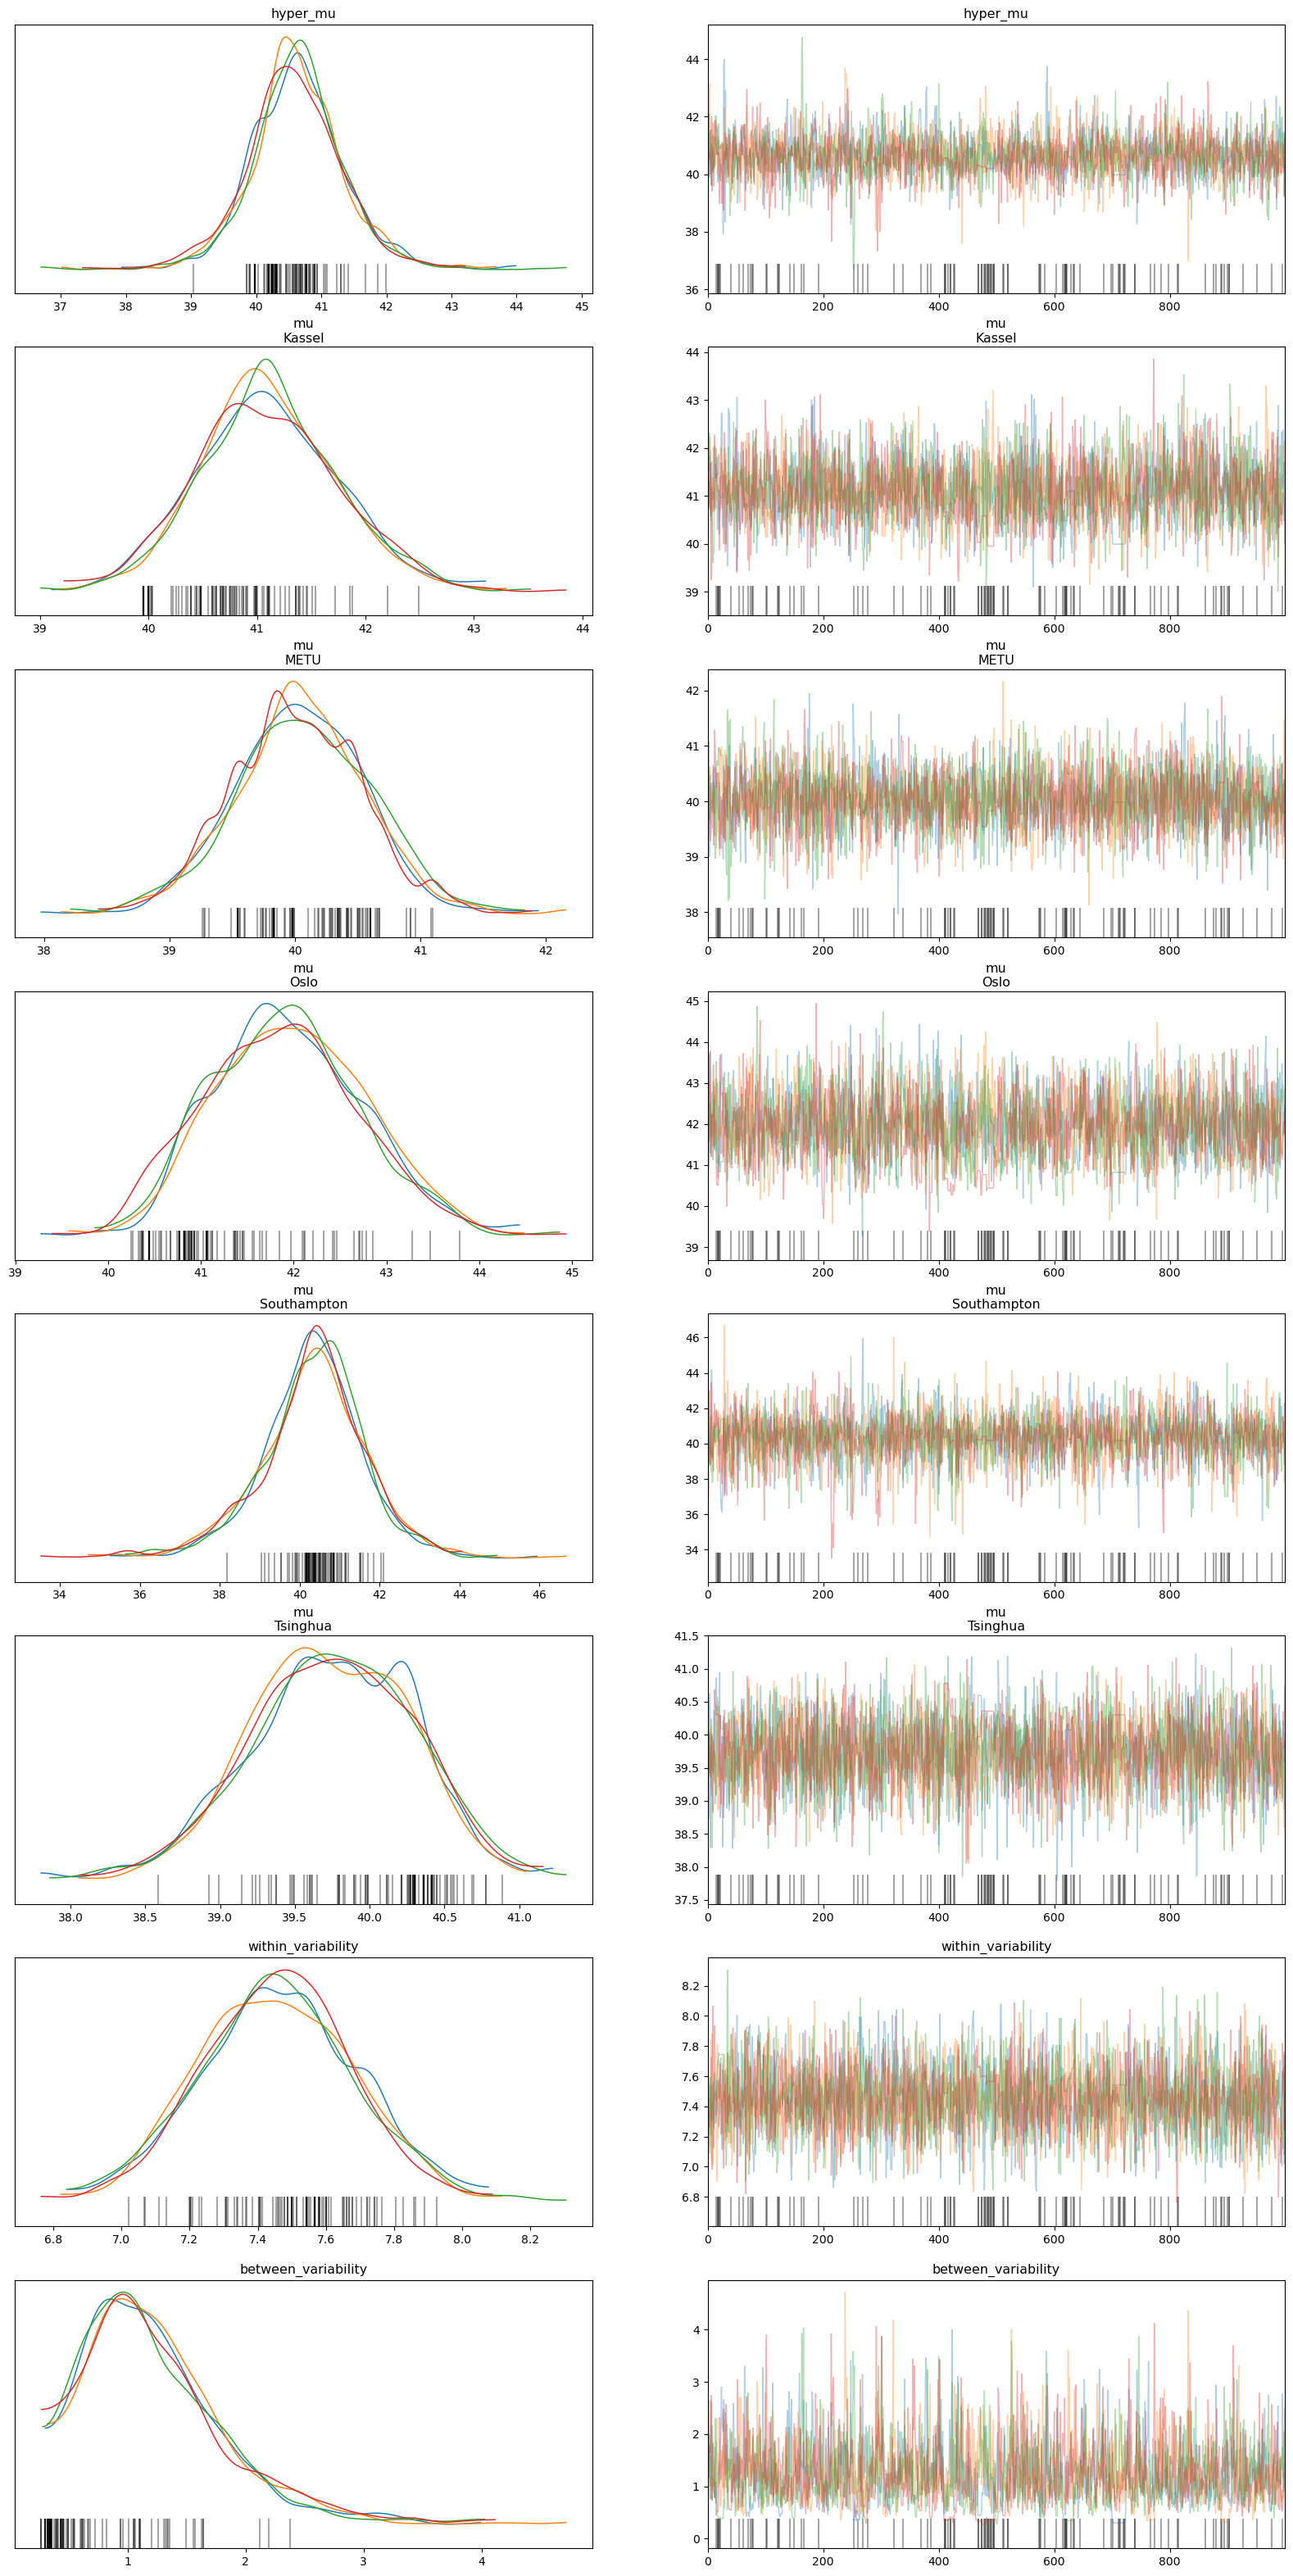

In [49]:
with partial_pooled_model:
    az.plot_trace(partial_trace,
                  compact=False,
                  figsize=(20,40))

## Within- vs between-group variability  

* 在完全池化模型中，变异性的来源只有一种，即个体观测值 $Y$ 在总体中的变异  ($\sigma$)  
* 在非池化模型中，变异来源分散在不同站点中，即个体观测值在不同站点中的变异 ($\sigma_j$)  

在部分池化模型中，我们可以把个体观测值$Y$的变异来源分解成两个部分：  
* 组内变异 $\sigma_y^2$  
* 组间变异 $\sigma_{\mu}^2$  

$$  
\text{Var}(Y_{ij}) = \sigma_y^2 + \sigma_{\mu}^2  
$$  


![Image Name](https://cdn.kesci.com/upload/s5eppwep1v.png?imageView2/0/w/600/h/600)  

类似于单因素方差分析  

$$  
\begin{split}  
\frac{\sigma^2_y}{\sigma^2_\mu + \sigma^2_y}  
& = \text{ $\text{Var}(Y_{ij})$ 可以被组内方差解释的部分} \\  
\frac{\sigma^2_\mu}{\sigma^2_\mu + \sigma^2_y}  
& = \text{$\text{Var}(Y_{ij})$ 可以被组间方差解释的部分} \\  
\end{split}  
$$  


* 组间方差远大于组内方差($\sigma_\mu > \sigma_y$)，那么组间方差可以解释大部分观测值的变异  
* 组间方差远小于组内方差($\sigma_\mu < \sigma_y$)，那么组与组之间的区别就不是很明显


* 此外，若组间方差远大于组内方差，则可以说明组内的变异性很小，组内分数高度相关  

$$  
\text{Cor}(Y_{ij}, Y_{kj}) = \frac{\sigma^2_\mu}{\sigma^2_\mu + \sigma^2_y}  
$$  

* 下图展示了三种组间方差与组内方差的分布情况(横轴为方差的大小，蓝色为组间方差，黑色为组内方差)  
![Image Name](https://cdn.kesci.com/upload/s5equxkezx.png?imageView2/0/w/960/h/960)  

- 组别越独特，σμ 相对越大，每**组内的相关性就越大**。  
- 图 (a) 中，组间变异是组内变异的4倍，此时组内相关性为 0.8，接近于 1。  
- 图 (c) 中，组间变异是组内变异的1/4倍，组内相关性为 0.2，接近 0。

我们可以使用`az.summary`来总结后验参数估计的情况，并计算组间组内变异和相关性

In [28]:
# 提取组间和组内变异
partial_para_sum = az.summary(partial_trace)
between_sd = partial_para_sum.loc["between_variability","mean"]
within_sd = partial_para_sum.loc["within_variability","mean"]
# 计算变异占比
var = between_sd**2 + within_sd**2
print("被组间方差所解释的部分：", between_sd**2/var)
print("被组内方差所解释的部分：", within_sd**2/var)
print("组内相关：",between_sd**2/var)

被组间方差所解释的部分： 0.026528402875168874
被组内方差所解释的部分： 0.9734715971248311
组内相关： 0.026528402875168874


### 后验预测分布  

* 可以看到相比于非池化模型，在层级模型中不同组的后验预测可信区间的长度、后验预测均值都更为接近

In [29]:
partial_ppc = pm.sample_posterior_predictive(partial_trace,
                                            model=partial_pooled_model)
partial_hdi_sum = ppc_sum(ppc=partial_ppc,
                  data=df_first5)                                         

Sampling: [y_est]


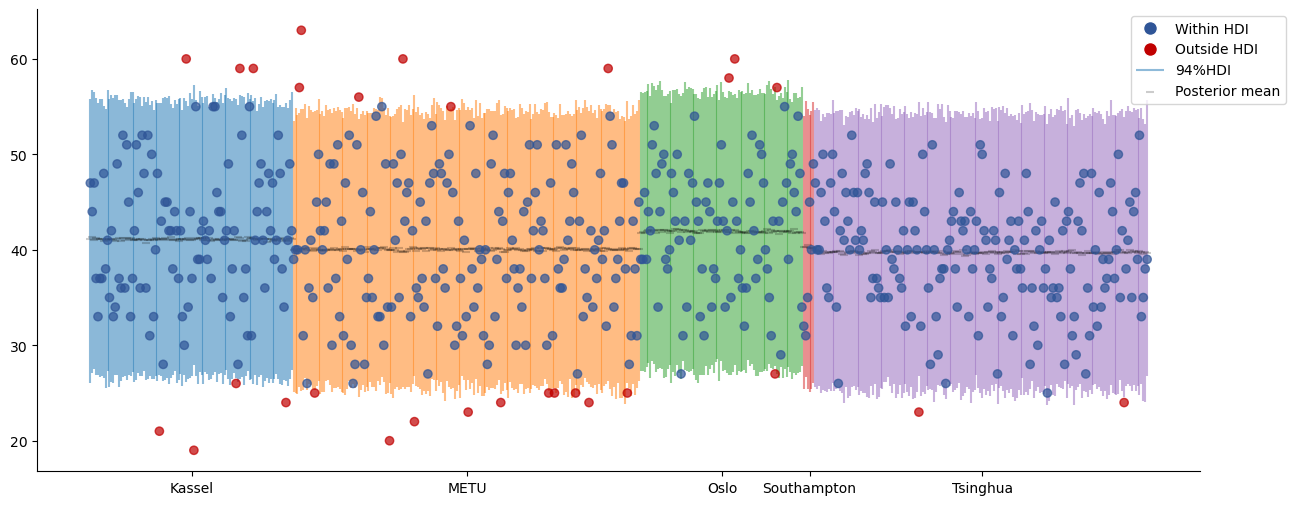

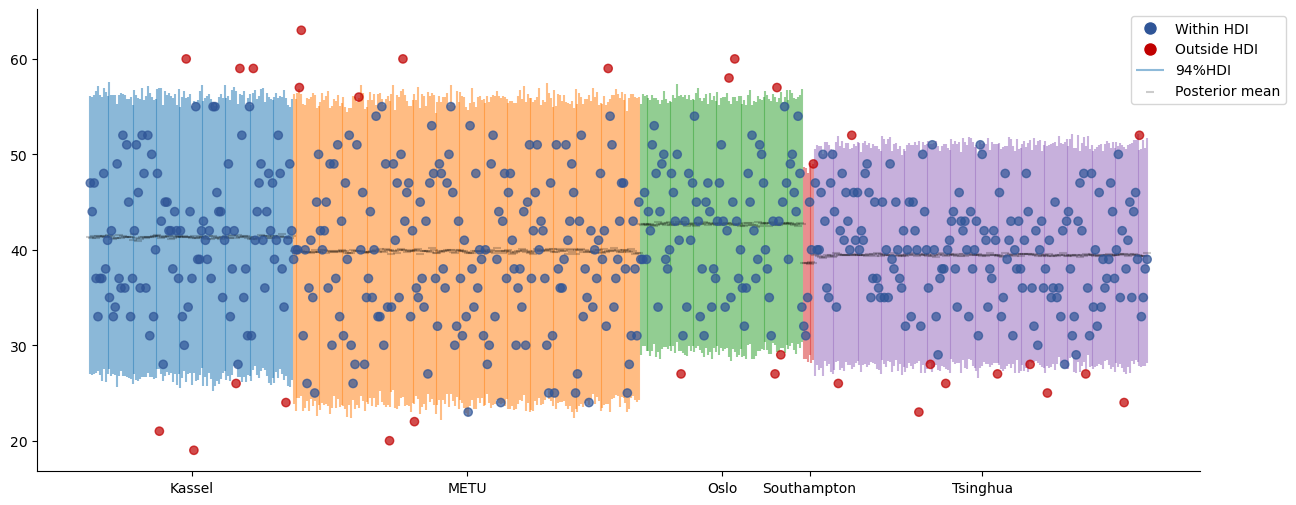

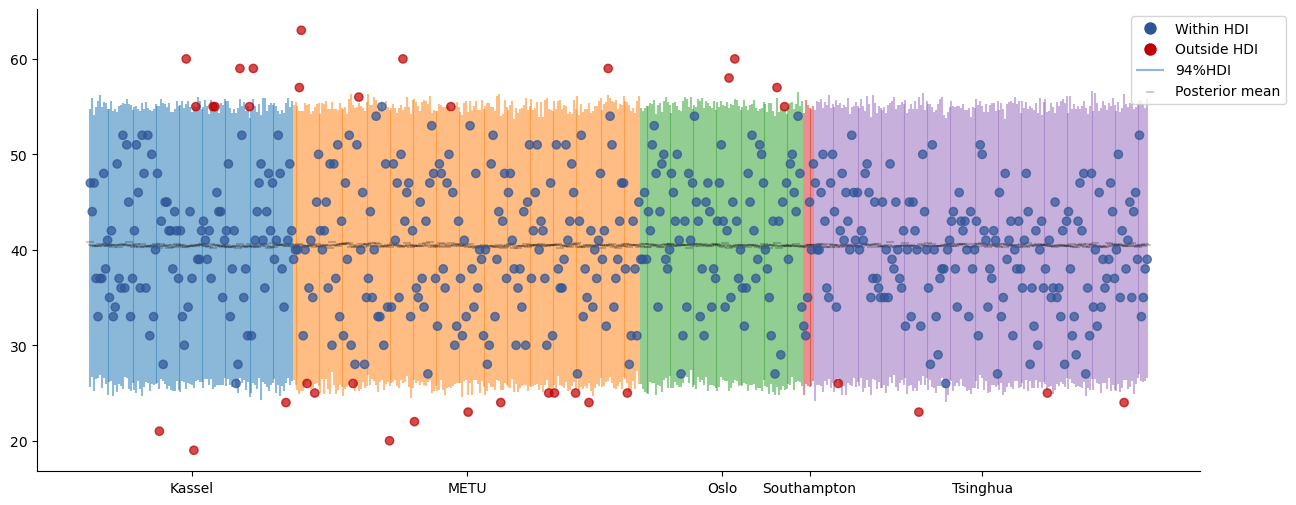

In [85]:
ppc_plot(hdi_sum=partial_hdi_sum)
ppc_plot(hdi_sum=no_hdi_sum)
ppc_plot(hdi_sum=complete_hdi_sum)

In [31]:
az.summary(partial_trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
hyper_mu             40.621  0.728  39.330   42.098      0.015    0.010   
mu[Kassel]           41.101  0.645  39.950   42.381      0.016    0.011   
mu[METU]             40.039  0.525  39.012   40.981      0.009    0.006   
mu[Oslo]             41.925  0.802  40.432   43.378      0.023    0.016   
mu[Southampton]      40.324  1.329  37.615   42.753      0.025    0.018   
mu[Tsinghua]         39.747  0.535  38.737   40.699      0.012    0.008   
within_variability    7.457  0.225   7.043    7.890      0.004    0.003   
between_variability   1.231  0.608   0.297    2.306      0.018    0.013   

                     ess_bulk  ess_tail  r_hat  
hyper_mu               2419.0    2645.0    1.0  
mu[Kassel]             1658.0     891.0    1.0  
mu[METU]               3306.0    2520.0    1.0  
mu[Oslo]               1119.0     297.0    1.0  
mu[Southampton]        3092.0    2360.0    1.0  
mu[Tsinghua]           2057.0    1949.0    1.0  
within_variability     2872.0    2644.0    1.0  
between_variability     701.0     286.0    1.0

## Shrinkage & the bias-variance trade-off  

从下图和表格中可以发现，三个模型的关系：  
* 部分池化模型的超参数 (hyper_mu)的后验分布接近完全池化模型估计的参数 (mu)  
* 部分池化模型中对站点参数的估计 (mu[?]) 的后验分布接近非池化模型估计的参数 (mu[?])  
* 对于有的站点来说，相比于非池化模型，部分池化模型中的参数 (mu[?]) 更加靠近完全池化模型，这就是**分层模型的收缩 (shrinkage) 现象**。  
	* 例如，非池化模型中mu[Southampton]为38.6，而部分池化模型的mu[Southampton]=40.4，更加接近 完全池化模型的 mu 40.5。

In [99]:
# 提取三个模型参数后验，筛选中其中含有mu参数的部分
partial_stats = az.summary(partial_trace, var_names=["mu"], filter_vars = "like", kind="stats")
no_stats = az.summary(no_trace, var_names=["mu"], filter_vars = "like", kind="stats")
complete_stats = az.summary(complete_trace, var_names=["mu"], filter_vars = "like", kind="stats")
# 设置一列，表明参数来源
complete_stats['source'] = 'Complete pool'
no_stats['source'] = 'No pool'
partial_stats['source'] = 'Partial pool'
# 合并三个模型的结果
df_compare = pd.concat([complete_stats.reset_index(),
                        no_stats.reset_index(),
                        partial_stats.reset_index()])
#设置索引，表明参数来源
df_compare.set_index(['source', df_compare.index], inplace=True)
df_compare

index    mean     sd  hdi_3%  hdi_97%
source                                                          
Complete pool 0               mu  40.454  0.323  39.820   41.027
No pool       0       mu[Kassel]  41.358  0.738  39.991   42.810
              1         mu[METU]  39.862  0.620  38.717   41.010
              2         mu[Oslo]  42.711  0.729  41.361   44.085
              3  mu[Southampton]  38.610  1.935  34.969   42.275
              4     mu[Tsinghua]  39.470  0.447  38.624   40.284
Partial pool  0         hyper_mu  40.621  0.728  39.330   42.098
              1       mu[Kassel]  41.101  0.645  39.950   42.381
              2         mu[METU]  40.039  0.525  39.012   40.981
              3         mu[Oslo]  41.925  0.802  40.432   43.378
              4  mu[Southampton]  40.324  1.329  37.615   42.753
              5     mu[Tsinghua]  39.747  0.535  38.737   40.699

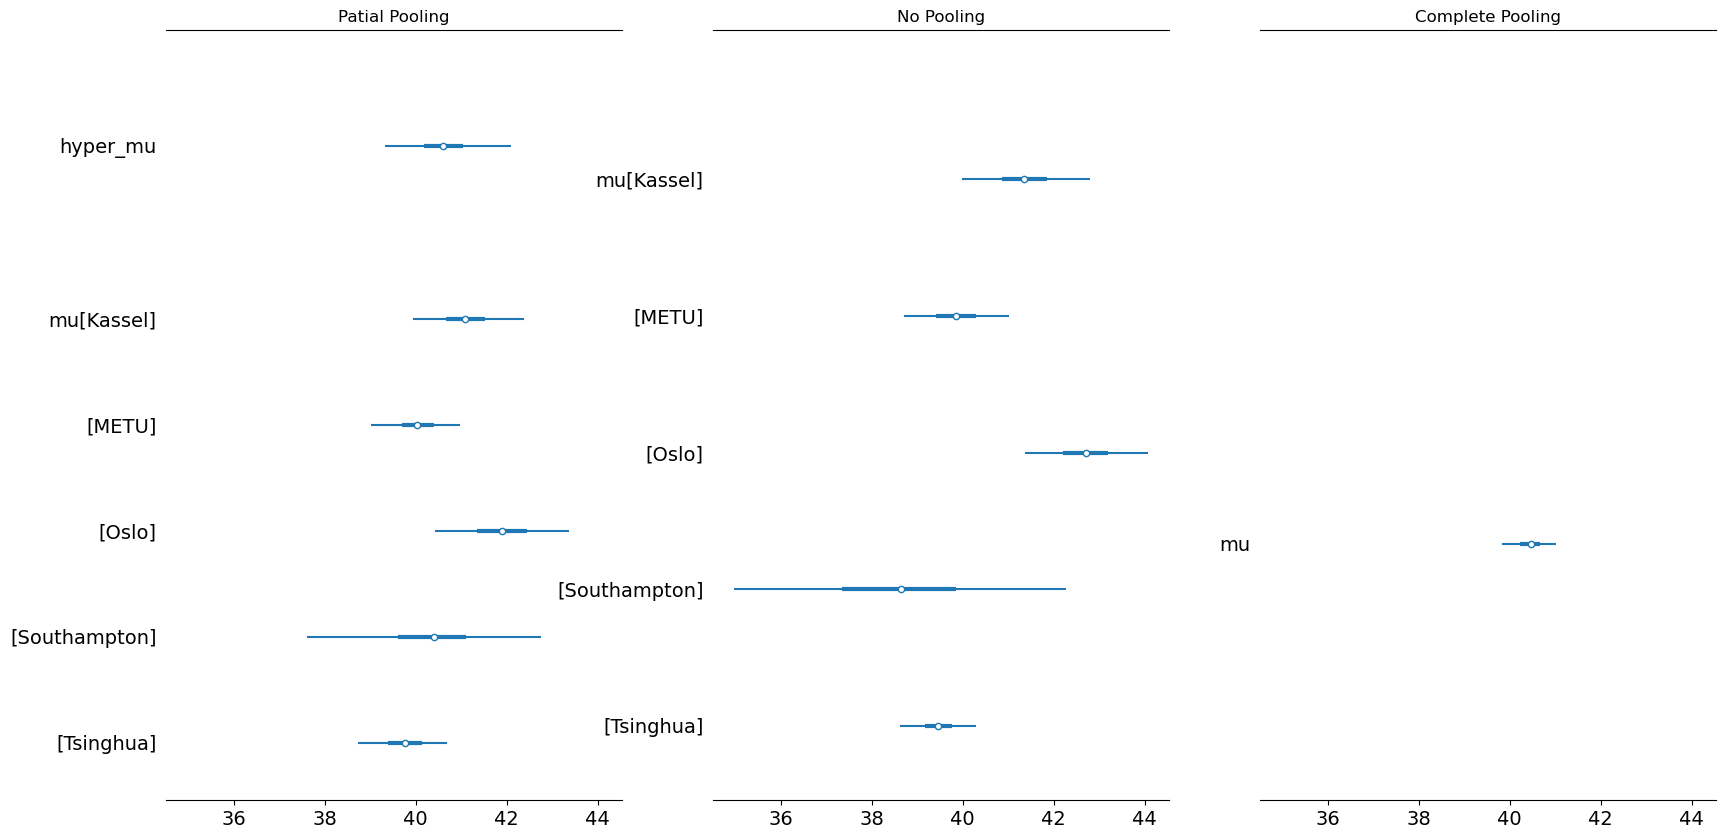

In [32]:
# 设置三个绘制坐标轴
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10), sharex=True)

# 绘制三个模型参数后验
az.plot_forest(partial_trace, var_names=["mu"], filter_vars = "like", combined=True, ax=ax1)
ax1.set_title("Patial Pooling")
az.plot_forest(no_trace, var_names=["mu"], filter_vars = "like", combined=True, ax=ax2)
ax2.set_title("No Pooling")
az.plot_forest(complete_trace, var_names=["mu"], filter_vars = "like", combined=True, ax=ax3)
ax3.set_title("Complete Pooling")

plt.show()

* 在完全池化模型中，对于每一个站点来说，后验估计均值都是相同的，在弱先验的情况下，后验估计均值约等于所有观测值的平均值  
$$  
\overline{y}_{\text{global}} = \frac{1}{n}\sum_{\text{all } i,j }y_{ij}  
$$  

* 在非池化模型中，对于每一个站点来说，其后验估计均值的估计只来自该组内部，在弱先验的情况下，后验估计均值约等于该组内所有观测值的平均值  
$$  
\overline{y}_j = \frac{1}{n_j}\sum_{i=1}^{n_j} y_{ij}  
$$  

* 在层级模型中，后验估计均值则是在完全池化和非池化模型中找到一个平衡，组间(group-specific)参数有可能更倾向完全池化模型，也有可能更倾向于非池化模型，这种现象被称为shrinkage  
> 当使用弱信息先验时，分层模型的后验平均预测结果（大致）是完全池化模型和非池化模型预测结果的加权平均  
$$  
\frac{\sigma^2_y}{\sigma^2_y + n_j \sigma^2_\mu} \overline{y}_{\text{global}} + \frac{n_j\sigma^2_\mu}{\sigma^2_y + n_j \sigma^2_\mu} \overline{y}_j  
$$  

* 我们可以分别绘制出每个观测值对应的后验预测均值，并观察这些后验预测均值在不同的模型之间发生了什么变化

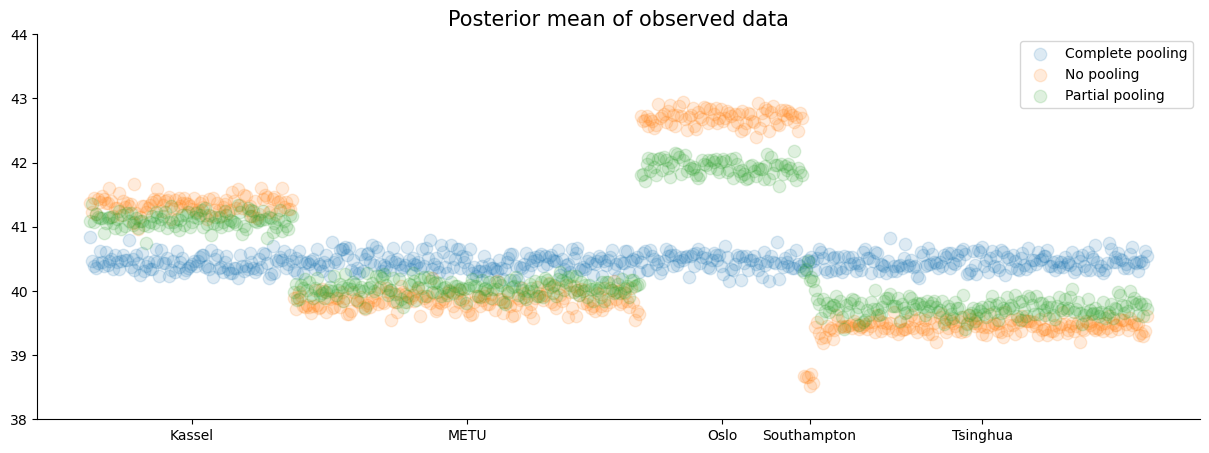

In [52]:
#设置画布大小
plt.figure(figsize=(15,5))
#绘制完全池化模型下每个点对应的后验预测均值
plt.scatter(complete_hdi_sum["obs_id"],
            complete_hdi_sum["mean"],
            alpha=0.15,
            s=80,
            label="Complete pooling")
#绘制非池化模型下每个点对应的后验预测均值
plt.scatter(no_hdi_sum["obs_id"],
            no_hdi_sum["mean"],
            alpha=0.15,
            s=80,
            label="No pooling")
#绘制部分池化模型下每个点对应的后验预测均值
plt.scatter(partial_hdi_sum["obs_id"],
            partial_hdi_sum["mean"],
            alpha=0.15,
            s=80,
            label="Partial pooling")
#设置y轴范围
plt.ylim(38,44)
#设置图例
plt.legend()
#计算每个站点的数据量，并根据数据量大小在x轴上进行刻度标识
count_per_site = df_first5.groupby(level="Site").size().values
cumulative_count = count_per_site.cumsum()
xtick = cumulative_count - count_per_site / 2
plt.xticks(xtick,df_first5["Site"].unique())
#设置标题
plt.title("Posterior mean of observed data",
          fontsize=15)
sns.despine()

收缩是指在分层模型中，特定群体的局部趋势(各站点的估计结果)被拉向或收缩向全局趋势(所有数据的整体趋势)的现象。  

$$  
\frac{\sigma^2_y}{\sigma^2_y + n_j \sigma^2_\mu} \overline{y}_{\text{global}} + \frac{n_j\sigma^2_\mu}{\sigma^2_y + n_j \sigma^2_\mu} \overline{y}_j  
$$  

* 收缩的大小 (即完全池化模型均值和非池化模型均值的权重)，取决于站点的数量 $n_j$ 以及 组内和组间变异性（$\sigma_y$和 $\sigma_μ$）的比。  
* 当站点的数量越少时，缩减率会增加。即我们越来越依赖全局趋势来了解一个组别很少 (可能意味着不可靠)的结果。  
* 当组别内的变异性$\sigma_y$与组别间的变异性 $\sigma_μ$ 相比较大时，缩减会增加。即当各站点之间的差异很小时，我们会更依赖于用全局趋势来理解其中一个站点的数据。  
> 这也说明，为什么 mu[Southampton] 受到的收缩影响最严重，因为 Southampton 站点的数据量 n 很少，并且组内 $\sigma_y$ 变异很大。  

![Image Name](https://cdn.kesci.com/upload/s5equxkezx.png?imageView2/0/w/960/h/960)  

层次模型在完全池化和无池化之间取得了平衡，优势在于：  

1. 将对不同群体(站点)的观察结果推广到更广泛的总体中  
2. 在了解任何单个群体时，借用所有其他群体的信息  

这也导致了它的缺点：  
* 如果站点数量少，并且组内变异大，那么我们对于总体和不同组别(站点)的估计都可能存在偏差

**bias-variance trade-off 偏差-方差权衡**  


|               | 完全池化                       | 非池化                                 | 部分池化               |  
| ------------- | ------------------------------ | -------------------------------------- | ---------------------- |  
| 特点          | 仅考虑总体的变异，模型过于简单 | 仅考虑各组别的差异，结果难以推广到总体 | 同时考虑组间和组内变异 |  
| 偏差-方差权衡 | 有较高的偏差和较低的方差       | 较低的偏差和较高的方差                 | 更为平衡               |  


## 预测新组的数据

* 我们可以根据当前的层级模型对新组别的数据进行预测，如"Zurich"站点

* 在pymc中，只要在`pm.sample_posterior_predictive`中传入层级模型的后验参数采样结果，即可以在层级模型的基础上对新数据生成预测

* 预测结果储存在`.predictions`中

In [54]:
# 选择站点为"Zurich"的数据
new_group = df_raw[df_raw.Site=="Zurich"]
# 生成被试索引
new_group["obs_id"] = range(len(new_group))
# 生成站点索引
new_group["site_idx"] = pd.factorize(new_group.Site)[0]

In [55]:
new_coords = {"site": new_group["Site"].unique(),
          "obs_id": new_group.obs_id}

with pm.Model(coords=new_coords) as partial_pooled_pred:
    # Hyperpriors
    var_y = pm.Exponential("within_variability", 1)
    var_mu = pm.Exponential("between_variability", 1)
    hyper_mu = pm.Normal("hyper_mu", mu=40, sigma=20)
    # 在这里我们需要传入一个新的参数名，因为传入的是一个新站点
    new_mu = pm.Normal("new_mu", mu=hyper_mu, sigma=var_mu, dims="site")
    # 其他的设置并没有发生改变
    g = pm.MutableData("g", new_group.site_idx, dims="obs_id")

    likelihood = pm.Normal("y_est", mu=new_mu[g], sigma=var_y, observed=new_group.scontrol, dims="obs_id")
    # 进行后验预测估计，注意使用的是上一个模型的后验参数估计，partial_trace
    pred_trace = pm.sample_posterior_predictive(partial_trace,
                                                var_names=["y_est"],
                                                predictions=True,
                                                extend_inferencedata=True,
                                                random_seed=84735)

Sampling: [new_mu, y_est]


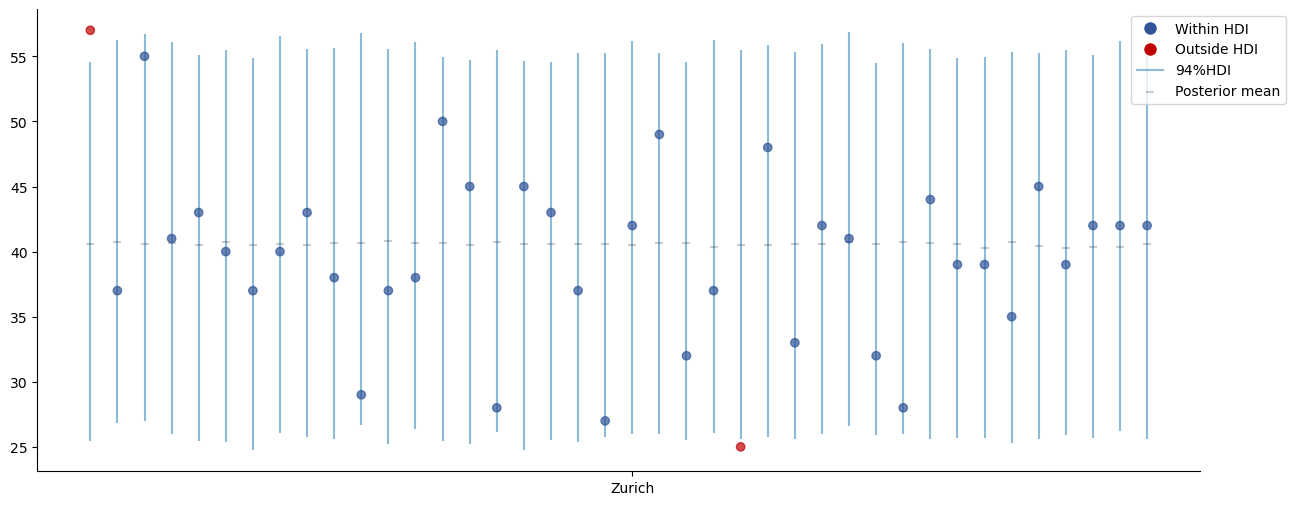

In [83]:
pred_hdi_sum = ppc_sum(ppc=pred_trace.predictions,data=new_group)
ppc_plot(pred_hdi_sum)

## bambi code  

最后，我们演示如何通过 bambi 来实现三种模型。

**完全池化模型**  

$$  
\begin{split}  
Y_{ij} | \mu, \sigma & \sim N(\mu, \sigma^2) \\  
\mu    & \sim N(0, 50^2) \\  
\sigma & \sim \text{Exp}(1) \\  
\end{split}  
$$  

* 观测数据 Y 主要受到 $\mu$ 的影响。在 bambi 中，可以通过 `"scontrol ~ 1"` 来表示这种关系。  
* 结果中的 Intercept	代表了  $\mu$； scontrol_sigma 代表 $\sigma$。

In [34]:
complete_model = bmb.Model("scontrol ~ 1", df_first5,
                           family="gaussian")
complete_idata = complete_model.fit(random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [scontrol_sigma, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.


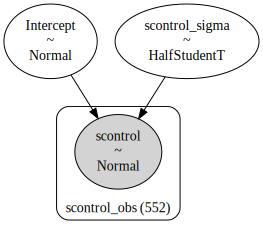

In [35]:
complete_model.graph()

In [36]:
az.summary(complete_idata)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept       40.451  0.324  39.888   41.076      0.005    0.004    3546.0   
scontrol_sigma   7.557  0.223   7.097    7.933      0.004    0.002    4044.0   

                ess_tail  r_hat  
Intercept         2746.0    1.0  
scontrol_sigma    2971.0    1.0

**非池化模型**  

$$  
Y_{ij} | \mu_j, \sigma \sim N(\mu_j, \sigma^2) \\  

\mu_j  \sim N(0, 50^2) \\  

\sigma \sim \text{Exp}(1) \\  
$$  

* 该模型的关键在于让每一个站点拥有一个独特的参数 $\mu_j$，对应 "scontrol ~ 0 + C(Site)"，其中的 0 表示去掉回归模型截距。  
* 注意，不同于之前的 pymc 模型，bambi 默认认为 $\sigma$ 在各站点间是相同的。  
* 从结果可以看到：C(Site)[???] 代表不同站点的均值。

In [37]:
no_model = bmb.Model("scontrol ~ 0 + C(Site)", df_first5,
                     categorical="Site")
no_idata = no_model.fit(random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [scontrol_sigma, C(Site)]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.


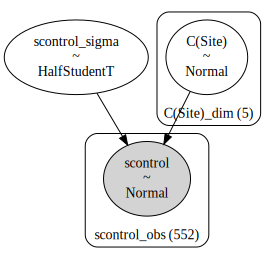

In [38]:
no_model.graph()

In [39]:
az.summary(no_idata)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
C(Site)[Kassel]       41.310  0.745  39.994   42.762      0.009    0.006   
C(Site)[METU]         39.846  0.555  38.805   40.892      0.007    0.005   
C(Site)[Oslo]         42.678  0.791  41.127   44.081      0.010    0.007   
C(Site)[Southampton]  38.654  3.025  32.857   44.358      0.038    0.027   
C(Site)[Tsinghua]     39.464  0.545  38.451   40.465      0.007    0.005   
scontrol_sigma         7.485  0.229   7.067    7.919      0.003    0.002   

                      ess_bulk  ess_tail  r_hat  
C(Site)[Kassel]         6910.0    2990.0    1.0  
C(Site)[METU]           5787.0    3084.0    1.0  
C(Site)[Oslo]           6874.0    3339.0    1.0  
C(Site)[Southampton]    6249.0    3288.0    1.0  
C(Site)[Tsinghua]       6301.0    3418.0    1.0  
scontrol_sigma          5709.0    3180.0    1.0

**部分池化模型**  

$$  
\begin{split}  
Y_{ij} | \mu_j, \sigma_y & \sim N(\mu_j, \sigma_y^2) \;\; \text{ with } \;\; \mu_j = \mu + b_{j}  \\  
b_{j} | \sigma_\mu    & \stackrel{ind}{\sim} N(0, \sigma_\mu^2) \\  
\mu           & \sim N(40, 20^2) \\  
\sigma_y      & \sim \text{Exp}(1) \\  
\sigma_\mu    & \sim \text{Exp}(1) \\  
\end{split}  
$$  

* 部分池化模型的关键在于，参数的层级依赖关系。  
* 而 bambi 提供了更简单的方法构建分层模型 `"scontrol ~ 1 + (1|Site)"`。  
	*  在完全池化模型 `"scontrol ~ 1"` 的基础上加入 `(1|Site)` 分层结构，就定义了好了分层模型。  
	*  注意，bambi 默认使用之前提到的第二种分层模型的定义形式 (线性模型的定义形式)  
*  从结果可以看到：  
	*  Intercept 代表了全局总体的均值，1|Site_sigma 代表了 不同站点形成的变异，即组间变异。  
	*  1|Site[???] 代表不同站点相对于全局总体的均值 Intercept 的偏移，例如，站点 Kassel	的均值 = Intercept + 1|Site[Kassel]	= 40.61+0.57 = 41.18  
	*  scontrol_sigma 为组内变异。

In [40]:
partial_model = bmb.Model("scontrol ~ 1 + (1|Site)", df_first5,
                     categorical="Site")
partial_idata = partial_model.fit(random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [scontrol_sigma, Intercept, 1|Site_sigma, 1|Site_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.


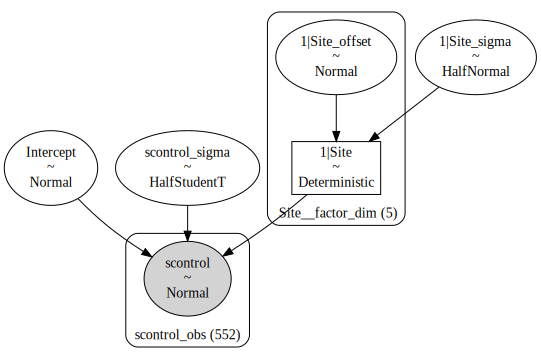

In [41]:
partial_model.graph()

In [42]:
az.summary(partial_idata)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept            40.733  1.070  38.621   42.615      0.133    0.097   
scontrol_sigma        7.481  0.232   7.024    7.890      0.006    0.004   
1|Site_sigma          1.921  1.241   0.027    4.270      0.087    0.069   
1|Site[Kassel]        0.451  1.169  -1.778    2.631      0.116    0.082   
1|Site[METU]         -0.751  1.162  -3.016    1.341      0.150    0.146   
1|Site[Oslo]          1.430  1.216  -0.541    3.845      0.097    0.069   
1|Site[Southampton]  -0.572  1.681  -4.199    2.269      0.072    0.054   
1|Site[Tsinghua]     -1.067  1.143  -3.352    0.915      0.128    0.136   

                     ess_bulk  ess_tail  r_hat  
Intercept               165.0      43.0   1.03  
scontrol_sigma         1704.0    1435.0   1.00  
1|Site_sigma            328.0     216.0   1.01  
1|Site[Kassel]          186.0      48.0   1.02  
1|Site[METU]            120.0      41.0   1.03  
1|Site[Oslo]            230.0      54.0   1.02  
1|Site[Southampton]     621.0     400.0   1.01  
1|Site[Tsinghua]        203.0      50.0   1.03

**🎯开放式练习**  

尝试使用 bambi 构建分层模型：  
1. 自行选取其他站点的数据进行分析。  
2. 可以尝试使用部分池化中的第一种公式构建分层模型，提示：可使用`"scontrol ~ 0 + (1|Site)"`构建模型。  
3. 比较组间组内变异的差异。  
4. 使用 `az.plot_forest` 绘制站点参数森林图。  
5. 思考分层模型带来的收缩效应 (shrinkake)。

## 总结  

在本节课中，我们学习了部分池化和层级模型(hierarchical model)：  
- 了解层级数据结构的形式，区分了三种建模方法：完全池化(complete pooling),  非池化(no pooling), 部分池化(patial pooling)  
- 讨论了组间变异(between variability)和组内变异(within variability)的差异，以及偏差方差权衡  
- 通过pymc 和 bambi 实现三种不同的模型  
